In [20]:
#load packages
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

#misc libraries
import random
import time


#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
#from pandas.tools.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

Python version: 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
pandas version: 0.24.1
matplotlib version: 3.0.2
NumPy version: 1.15.4
SciPy version: 1.2.0
IPython version: 7.2.0
scikit-learn version: 0.20.2
-------------------------
test.csv
train.csv



In [21]:
train_file = "../input/train.csv"
test_file = "../input/test.csv"

train_df = pd.read_csv(train_file, index_col = 0, dtype={"Age": np.float64})
test_df = pd.read_csv(test_file, index_col = 0, dtype={"Age": np.float64})

train_df['train'] = True
test_df['train'] = False
df = pd.concat([train_df, test_df], sort=False)
del train_df
del test_df

In [22]:
import re

#df = df.dropna(how='all', subset = ['Embarked'])
#df = df.dropna(how='all', subset = ['Fare'])
df['Embarked'] = df['Embarked'].fillna('S')

#fill age and create cat
#df['Age'] = df['Age'].fillna(value = df['Age'].median())
age_avg = df['Age'].mean()
age_std = df['Age'].std()
age_null_count = df['Age'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
df['Age'][np.isnan(df['Age'])] = age_null_random_list

#replace Fare and create categories
df['Fare'] = df['Fare'].fillna(df['Fare'].loc[(df['Pclass'] == 3) & (df['Embarked'] == 2) & (df['Cabin'] == 186)].median())

df['FareCat'] = pd.qcut(df['Fare'], 4)

#find the Surname to det families
df['Surname'] = df['Name'].apply(lambda x: x.split(',')[0].lower())
#find the name length
df["NameLen"] = df["Name"].apply(lambda x: len(x))
df['NameLenCat'] = pd.cut(df['NameLen'].astype(int), 5)

#add total nb of relatives on the boat
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = 1 #initialize to yes/1 is alone
df['IsAlone'].loc[df['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1 
    

#find the title
df['Title'] = df['Name'].apply(lambda x: re.search('([A-Za-z]+)\.', x).group(1))
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3,
                 "Master": 4, "Dr": 5, "Rev": 6,
                 "Major": 7, "Col": 7, "Mlle": 2,
                 "Mme": 3,"Don": 9,"Dona": 9,
                 "Lady": 10, "Countess": 10,
                 "Jonkheer": 10, "Sir": 9,
                 "Capt": 7, "Ms": 2}
df["TitleCode"] = df.loc[:,'Title'].map(title_mapping)

le = sklearn.preprocessing.LabelEncoder()
#create an index for each family by comparing Surname and numbers giving relatives
arrays = [df['SibSp'].values, df['Parch'].values, df['Surname'].values]
joint_criterias = [str(arrays[0][i]) + str(arrays[1][i]) + str(arrays[2][i]) for i in range(df.shape[0])]
df['FamilyInd'] = le.fit_transform(joint_criterias)

#add mean, min and max age of the family
df['MeanAge'] = df.groupby('FamilyInd')['Age'].transform(lambda x: x.mean())
df['MinAge'] = df.groupby('FamilyInd')['Age'].transform(lambda x: x.min())
df['MaxAge'] = df.groupby('FamilyInd')['Age'].transform(lambda x: x.max())

#create categories with Age
age_columns = ['Age', 'MeanAge', 'MinAge', 'MaxAge']
for col in age_columns:
    df[col + 'Cat'] = pd.cut(df[col].astype(int), 5)
    
#Encode the rest
cols = ['Embarked', 'Sex', 'FareCat', 'AgeCat', 'MeanAgeCat', 'MinAgeCat', 'MaxAgeCat', 'NameLenCat']
for col in cols:    
    df[col + 'Code'] = le.fit_transform(df[col].values.astype(str))


In [23]:
drop_columns = ['Cabin', 'Ticket']
df = df.drop(columns = drop_columns)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 34 columns):
Survived          891 non-null float64
Pclass            1309 non-null int64
Name              1309 non-null object
Sex               1309 non-null object
Age               1309 non-null float64
SibSp             1309 non-null int64
Parch             1309 non-null int64
Fare              1308 non-null float64
Embarked          1309 non-null object
train             1309 non-null bool
FareCat           1308 non-null category
Surname           1309 non-null object
NameLen           1309 non-null int64
NameLenCat        1309 non-null category
FamilySize        1309 non-null int64
IsAlone           1309 non-null int64
Title             1309 non-null object
TitleCode         1309 non-null int64
FamilyInd         1309 non-null int64
MeanAge           1309 non-null float64
MinAge            1309 non-null float64
MaxAge            1309 non-null float64
AgeCat            1309 non-null cate

In [25]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

In [26]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
            'Fare', 'Embarked', 'NameLen',
            'FamilySize', 'IsAlone', 'Title', 'MeanAge', 'MinAge', 'MaxAge']
features_code = ['Pclass', 'SibSp', 'Parch',
                 'FamilySize', 'IsAlone', 'TitleCode',
                 'EmbarkedCode', 'SexCode', 'FareCatCode',
                 'AgeCatCode', 'MeanAgeCatCode', 'MinAgeCatCode', 'MaxAgeCatCode',
                 'NameLenCatCode']

Target = ['Survived']

assert (len(features) == len(features_code))

In [27]:
train_df = df.loc[lambda df:df['train'] == True].drop(columns = 'train')
test_df = df.loc[lambda df:df['train'] == False].drop(columns = 'train')

X_tr, X_val, y_tr, y_val = model_selection.train_test_split(train_df[features], train_df[Target], test_size=0.2, random_state=42)
XCat_tr, XCat_val, yCat_tr, yCat_val = model_selection.train_test_split(train_df[features_code], train_df[Target], test_size=0.2, random_state=42)

In [28]:
for x in features_code:
    if train_df[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(df[[x, Target[0]]].groupby(x, as_index=False).apply(lambda x:x.mean()))
        print('-'*10, '\n')

Survival Correlation by: Pclass
   Pclass  Survived
0     1.0  0.629630
1     2.0  0.472826
2     3.0  0.242363
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0    0.0  0.345395
1    1.0  0.535885
2    2.0  0.464286
3    3.0  0.250000
4    4.0  0.166667
5    5.0  0.000000
6    8.0  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0    0.0  0.343658
1    1.0  0.550847
2    2.0  0.500000
3    3.0  0.600000
4    4.0  0.000000
5    5.0  0.200000
6    6.0  0.000000
7    9.0       NaN
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0         1.0  0.303538
1         2.0  0.552795
2         3.0  0.578431
3         4.0  0.724138
4         5.0  0.200000
5         6.0  0.136364
6         7.0  0.333333
7         8.0  0.000000
8        11.0  0.000000
---------- 

Survival Correlation by: IsAlone
   IsAlone  Survived
0      0.0  0.505650
1      1.0  0.303538
---------- 

Survival Correlation by: TitleCode
   TitleCode  Survived
0       

In [29]:
#We see that Min et Mean Age are not that good. We drop them
#Too correlated between ages, lets drop all
#let's try to delete is alone as proposed by feat red
#let's also try to delete sis et parch

features = ['Pclass', 'Sex', 'Age',
            'Fare', 'Embarked', 'NameLen',
            'FamilySize', 'Title']
features_code = ['Pclass',
                 'FamilySize', 'TitleCode',
                 'EmbarkedCode', 'SexCode', 'FareCatCode',
                 'AgeCatCode',
                 'NameLenCatCode']

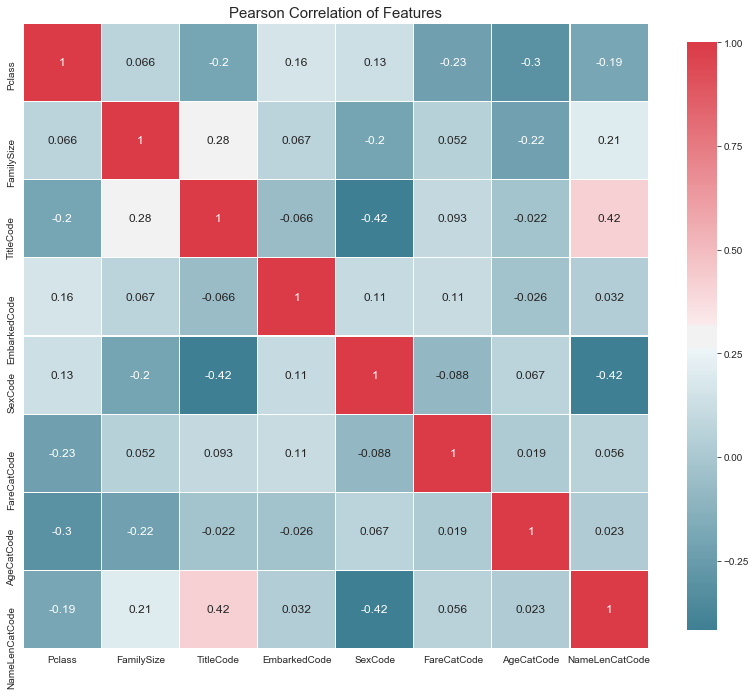

In [30]:
correlation_heatmap(train_df[features_code])

In [31]:
train_df[features_code].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
Pclass            891 non-null int64
FamilySize        891 non-null int64
TitleCode         891 non-null int64
EmbarkedCode      891 non-null int64
SexCode           891 non-null int64
FareCatCode       891 non-null int64
AgeCatCode        891 non-null int64
NameLenCatCode    891 non-null int64
dtypes: int64(8)
memory usage: 62.6 KB


In [32]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 42 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = train_df[Target]

#index through MLA and save performance to table
for i, alg in enumerate(MLA):

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[i, 'MLA Name'] = MLA_name
    MLA_compare.loc[i, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, train_df[features_code], train_df[Target].values.ravel(), cv  = cv_split)

    MLA_compare.loc[i, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[i, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[i, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[i, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(train_df[features_code], train_df[Target].values.ravel())
    MLA_predict[MLA_name] = alg.predict(train_df[features_code])

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.864045,0.839925,0.0630155,0.0376025
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.844195,0.837687,0.0535093,0.0306848
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.877341,0.836194,0.0666867,0.0715484
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.82809,0.835448,0.0486522,0.0343283
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.886142,0.83097,0.0592438,0.0847788
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.826592,0.81791,0.0589788,0.0548388
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.920037,0.816791,0.0516505,0.0104987
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.917978,0.810821,0.0559813,0.0115869
20,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.819288,0.809701,0.0529798,0.00194774
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.925843,0.803731,0.0670148,0.0103989


Text(0, 0.5, 'Algorithm')

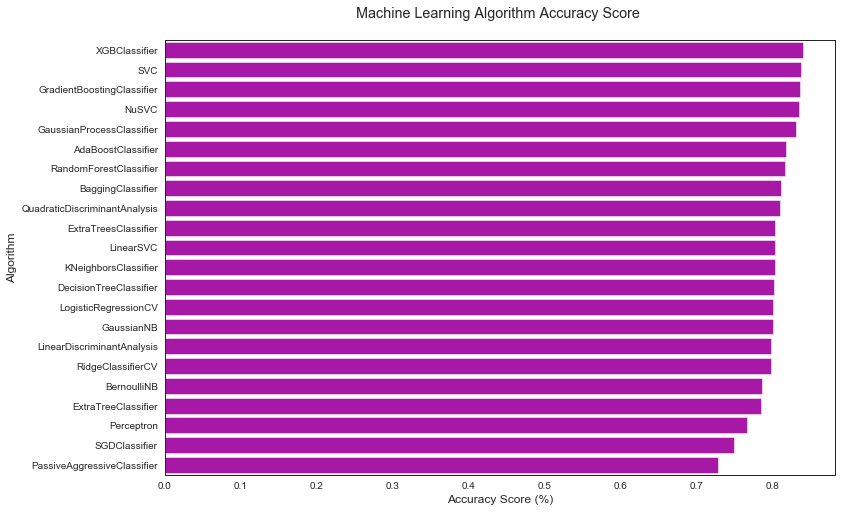

In [33]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [34]:
#base model
xgb = XGBClassifier()
base_results = model_selection.cross_validate(xgb, train_df[features_code], train_df[Target].values.ravel(), cv  = cv_split)
xgb.fit(train_df[features_code], train_df[Target].values.ravel())

print('BEFORE DT Parameters: ', xgb.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
#print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)

BEFORE DT Parameters:  {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
BEFORE DT Training w/bin score mean: 86.40
BEFORE DT Test w/bin score mean: 83.99
BEFORE DT Test w/bin score 3*std: +/- 6.30
----------


In [35]:
#base model // feature reduction
print('BEFORE DT RFE Training Shape Old: ', train_df[features_code].shape) 
print('BEFORE DT RFE Training Columns Old: ', train_df[features_code].columns.values)

print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)



#feature selection
xgb_rfe = feature_selection.RFECV(xgb, step = 1, scoring = 'accuracy', cv = cv_split)
xgb_rfe.fit(train_df[features_code], train_df[Target].values.ravel())

#transform x&y to reduced features and fit new model
#alternative: can use pipeline to reduce fit and transform steps: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
X_rfe = train_df[features_code].columns.values[xgb_rfe.get_support()]
rfe_results = model_selection.cross_validate(xgb, train_df[X_rfe], train_df[Target].values.ravel(), cv  = cv_split)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', train_df[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)

##pas vraiment efficace .......

BEFORE DT RFE Training Shape Old:  (891, 8)
BEFORE DT RFE Training Columns Old:  ['Pclass' 'FamilySize' 'TitleCode' 'EmbarkedCode' 'SexCode' 'FareCatCode'
 'AgeCatCode' 'NameLenCatCode']
BEFORE DT RFE Training w/bin score mean: 86.40
BEFORE DT RFE Test w/bin score mean: 83.99
BEFORE DT RFE Test w/bin score 3*std: +/- 6.30
----------
AFTER DT RFE Training Shape New:  (891, 8)
AFTER DT RFE Training Columns New:  ['Pclass' 'FamilySize' 'TitleCode' 'EmbarkedCode' 'SexCode' 'FareCatCode'
 'AgeCatCode' 'NameLenCatCode']
AFTER DT RFE Training w/bin score mean: 86.40
AFTER DT RFE Test w/bin score mean: 83.99
AFTER DT RFE Test w/bin score 3*std: +/- 6.30
----------


In [47]:
xgb = XGBClassifier(
 learning_rate =0.01,
 n_estimators=600,
 max_depth=3,
 min_child_weight=0.3,
 gamma=0.8,
 subsample=0.85,
 colsample_bytree=0.75,
 reg_alpha=0.01,
 seed=42)
base_results = model_selection.cross_validate(xgb, train_df[features_code], train_df[Target].values.ravel(), cv  = cv_split)
xgb.fit(train_df[features_code], train_df[Target].values.ravel())

print('AFTER DT Parameters: ', xgb.get_params())
print("AFTER DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("AFTER DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
#print("AFTER DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)

AFTER DT Parameters:  {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.75, 'gamma': 0.8, 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 0.3, 'missing': None, 'n_estimators': 600, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 42, 'silent': True, 'subsample': 0.85}
AFTER DT Training w/bin score mean: 85.88
AFTER DT Test w/bin score mean: 84.33
AFTER DT Test w/bin score 3*std: +/- 5.48
----------


In [37]:
predictions = xgb.predict(test_df[features_code])

In [38]:
PassengerId =np.array(test_df.index).astype(int)
my_prediction = pd.DataFrame(predictions.astype(int), PassengerId, columns = ["Survived"])

my_prediction.to_csv("../xgb.csv", index_label = ["PassengerId"])